In [78]:
!pip install feast

In [79]:
import feast

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor

## Loading the dataset

In [102]:
df_original = pd.read_csv('/content/mw_pw_profiles_2.csv', low_memory = False)

In [103]:
df_original.columns

Index(['player_id', 'match_id', 'gender', 'balls_per_over', 'start_date',
       'series_name', 'match_type', 'name_x', 'runs_scored', 'player_out',
       'balls_faced', 'fours_scored', 'sixes_scored', 'catches_taken',
       'run_out_direct', 'run_out_throw', 'stumpings_done', 'out_kind',
       'dot_balls_as_batsman', 'order_seen', 'balls_bowled', 'runs_conceded',
       'wickets_taken', 'bowled_done', 'lbw_done', 'maidens',
       'dot_balls_as_bowler', 'player_team', 'opposition_team', 'name_y',
       'unique_name', 'key_bcci', 'key_bcci_2', 'key_bigbash', 'key_cricbuzz',
       'key_cricheroes', 'key_crichq', 'key_cricinfo', 'key_cricinfo_2',
       'key_cricinfo_3', 'key_cricingif', 'key_cricketarchive',
       'key_cricketarchive_2', 'key_cricketworld', 'key_nvplay',
       'key_nvplay_2', 'key_opta', 'key_opta_2', 'key_pulse', 'key_pulse_2',
       'full_name', 'batting_style', 'bowling_style', 'playing_role', 'teams',
       'fantasy_score_batting', 'fantasy_score_bowling',


## Dropping Unnecessary columns :

In [104]:
df_original.drop(['gender', 'balls_per_over', 'series_name', 'name_y', 'unique_name','key_bcci', 'key_bcci_2', 'key_bigbash', 'key_cricbuzz',
       'key_cricheroes', 'key_crichq', 'key_cricinfo', 'key_cricinfo_2',
       'key_cricinfo_3', 'key_cricingif', 'key_cricketarchive',
       'key_cricketarchive_2', 'key_cricketworld', 'key_nvplay',
       'key_nvplay_2', 'key_opta', 'key_opta_2', 'key_pulse', 'full_name',
        'key_pulse_2', 'batting_style', 'bowling_style', 'playing_role', 'teams', ], axis = 1, inplace = True)

In [105]:
df_original.columns

Index(['player_id', 'match_id', 'start_date', 'match_type', 'name_x',
       'runs_scored', 'player_out', 'balls_faced', 'fours_scored',
       'sixes_scored', 'catches_taken', 'run_out_direct', 'run_out_throw',
       'stumpings_done', 'out_kind', 'dot_balls_as_batsman', 'order_seen',
       'balls_bowled', 'runs_conceded', 'wickets_taken', 'bowled_done',
       'lbw_done', 'maidens', 'dot_balls_as_bowler', 'player_team',
       'opposition_team', 'fantasy_score_batting', 'fantasy_score_bowling',
       'fantasy_score_total'],
      dtype='object')

In [106]:
df_original.head()

,player_id,match_id,start_date,match_type,name_x,runs_scored,player_out,balls_faced,fours_scored,sixes_scored,...,wickets_taken,bowled_done,lbw_done,maidens,dot_balls_as_bowler,player_team,opposition_team,fantasy_score_batting,fantasy_score_bowling,fantasy_score_total
0,00015688,1158348,2018-08-21,T20,M King,10,1,30,1,0,...,0,0,0,0,0,Sierra Leone,Namibia,5,8,17
1,00015688,1182644,2019-05-05,T20,M King,8,1,18,1,0,...,0,0,0,0,0,Sierra Leone,Uganda,3,0,7
2,00015688,1275107,2021-09-09,T20,M King,1,0,5,0,0,...,0,0,0,0,0,Sierra Leone,Nigeria,1,0,5
3,00015688,1275113,2021-09-15,T20,M King,0,0,0,0,0,...,0,0,0,0,0,Sierra Leone,Cameroon,0,0,4
4,00015688,1275125,2021-09-14,T20,M King,1,1,15,0,0,...,0,0,0,0,0,Sierra Leone,Uganda,-5,0,-1


## removal of null values

In [107]:
df_original = df_original.dropna()


In [108]:
df_original.isnull().sum()

,0
player_id,0
match_id,0
start_date,0
match_type,0
name_x,0
runs_scored,0
player_out,0
balls_faced,0
fours_scored,0
sixes_scored,0


## Sorting the dataframe using date

In [109]:
df_original['start_date'] = pd.to_datetime(df_original['start_date'], errors='coerce')

df_original.sort_values(by=['start_date'], inplace=True)
df_original.reset_index(drop=True, inplace=True)

In [110]:
df_original.head()

,player_id,match_id,start_date,match_type,name_x,runs_scored,player_out,balls_faced,fours_scored,sixes_scored,...,wickets_taken,bowled_done,lbw_done,maidens,dot_balls_as_bowler,player_team,opposition_team,fantasy_score_batting,fantasy_score_bowling,fantasy_score_total
0,f44af07f,63963,2001-12-19,Test,C White,39,1,93,6,0,...,0,0,0,2,39,England,India,45,0,49
1,de8cce37,63963,2001-12-19,Test,VVS Laxman,12,1,18,2,0,...,0,0,0,0,0,India,England,14,8,26
2,b6cd714f,63963,2001-12-19,Test,Sarandeep Singh,4,1,16,0,0,...,4,0,1,5,96,India,England,4,76,84
3,725529bc,63963,2001-12-19,Test,SC Ganguly,0,1,3,0,0,...,0,0,0,3,70,India,England,-4,0,0
4,0184dc35,63963,2001-12-19,Test,R Dravid,3,1,61,0,0,...,0,0,0,0,0,India,England,3,14,21


In [111]:
df_original.tail()

,player_id,match_id,start_date,match_type,name_x,runs_scored,player_out,balls_faced,fours_scored,sixes_scored,...,wickets_taken,bowled_done,lbw_done,maidens,dot_balls_as_bowler,player_team,opposition_team,fantasy_score_batting,fantasy_score_bowling,fantasy_score_total
416707,4e38a3d6,1485778,2025-05-20,T20,R Poddar,4,1,10,0,0,...,0,0,0,0,0,Nepal,Thailand,-2,0,2
416708,bd36bc39,1485778,2025-05-20,T20,S Chaturongrattana,0,0,0,0,0,...,0,0,0,0,8,Thailand,Nepal,0,16,20
416709,f6ddfe08,1485778,2025-05-20,T20,C Sutthiruang,0,0,0,0,0,...,0,0,0,0,10,Thailand,Nepal,0,12,16
416710,a2f46292,1473500,2025-05-20,T20,KK Ahmed,0,0,0,0,0,...,0,0,0,0,6,Chennai Super Kings,Rajasthan Royals,0,-4,0
416711,97e6e41a,1485778,2025-05-20,T20,K Kunwar,24,0,33,1,0,...,0,0,0,0,10,Nepal,Thailand,25,0,29


## Feature Engineering

In [186]:
df_features = df_original.copy()

In [187]:
label_encoder = preprocessing.LabelEncoder()
df_features['player_id']= label_encoder.fit_transform(df_features['player_id'])
df_features['player_team']= label_encoder.fit_transform(df_features['opposition_team'])

In [188]:
df_features.drop(['match_id'], inplace=True, axis=1)

In [189]:
df_features.drop(['out_kind'],inplace = True, axis = 1)

In [190]:
df_features = pd.get_dummies(df_features, columns = ['match_type'], drop_first = True, dtype = int)

In [191]:
df_features['strike_rate'] = (df_features['runs_scored'] / df_features['balls_faced'])*100

In [192]:
df_features['economy_rate'] = (df_features['runs_conceded'] / df_features['balls_bowled'])*100

In [193]:
df_features.drop(['balls_faced', 'runs_conceded', 'balls_bowled', 'player_out', 'dot_balls_as_batsman', 'dot_balls_as_bowler', 'fantasy_score_batting', 'fantasy_score_bowling'], inplace = True, axis = 1)

In [194]:
df_features['match_id'] = df_original['match_id']

In [195]:
df_features.columns

Index(['player_id', 'start_date', 'name_x', 'runs_scored', 'fours_scored',
       'sixes_scored', 'catches_taken', 'run_out_direct', 'run_out_throw',
       'stumpings_done', 'order_seen', 'wickets_taken', 'bowled_done',
       'lbw_done', 'maidens', 'player_team', 'opposition_team',
       'fantasy_score_total', 'match_type_MDM', 'match_type_ODI',
       'match_type_ODM', 'match_type_T20', 'match_type_Test', 'strike_rate',
       'economy_rate', 'match_id'],
      dtype='object')

In [196]:
df_features.drop(['order_seen'], inplace = True, axis = 1)

In [197]:
df_features['runs_scored_1'] = df_features['runs_scored'].shift(-1).ewm(span=1, adjust=False).mean()
df_features['runs_scored_2'] = df_features['runs_scored'].shift(-1).ewm(span=2, adjust=False).mean()
df_features['runs_scored_5'] = df_features['runs_scored'].shift(-1).ewm(span=5, adjust=False).mean()
df_features['runs_scored_10'] = df_features['runs_scored'].shift(-1).ewm(span=10, adjust=False).mean()

df_features['fours_scored_1'] = df_features['fours_scored'].shift(-1).ewm(span=1, adjust=False).mean()
df_features['fours_scored_5'] = df_features['fours_scored'].shift(-1).ewm(span=5, adjust=False).mean()
df_features['fours_scored_10'] = df_features['fours_scored'].shift(-1).ewm(span=10, adjust=False).mean()

df_features['sixes_scored_1'] = df_features['sixes_scored'].shift(-1).ewm(span=1, adjust=False).mean()
df_features['sixes_scored_5'] = df_features['sixes_scored'].shift(-1).ewm(span=5, adjust=False).mean()
df_features['sixes_scored_10'] = df_features['sixes_scored'].shift(-1).ewm(span=10, adjust=False).mean()

df_features['catches_taken_1'] = df_features['catches_taken'].shift(-1).ewm(span=1, adjust=False).mean()
df_features['catches_taken_5'] = df_features['catches_taken'].shift(-1).ewm(span=5, adjust=False).mean()
df_features['catches_taken_10'] = df_features['catches_taken'].shift(-1).ewm(span=10, adjust=False).mean()

df_features['run_out_direct_5'] = df_features['run_out_direct'].shift(-1).ewm(span=5, adjust=False).mean()
df_features['run_out_direct_10'] = df_features['run_out_direct'].shift(-1).ewm(span=10, adjust=False).mean()

df_features['run_out_throw_1'] = df_features['run_out_throw'].shift(-1).ewm(span=1, adjust=False).mean()
df_features['run_out_throw_5'] = df_features['run_out_throw'].shift(-1).ewm(span=5, adjust=False).mean()
df_features['run_out_throw_10'] = df_features['run_out_throw'].shift(-1).ewm(span=10, adjust=False).mean()

df_features['stumpings_done_5'] = df_features['stumpings_done'].shift(-1).ewm(span=5, adjust=False).mean()
df_features['stumpings_done_10'] = df_features['stumpings_done'].shift(-1).ewm(span=10, adjust=False).mean()

df_features['wickets_taken_1'] = df_features['wickets_taken'].shift(-1).ewm(span=1, adjust=False).mean()
df_features['wickets_taken_2'] = df_features['wickets_taken'].shift(-1).ewm(span=2, adjust=False).mean()
df_features['wickets_taken_5'] = df_features['wickets_taken'].shift(-1).ewm(span=5, adjust=False).mean()
df_features['wickets_taken_10'] = df_features['wickets_taken'].shift(-1).ewm(span=10, adjust=False).mean()

df_features['bowled_done_1'] = df_features['bowled_done'].shift(-1).ewm(span=1, adjust=False).mean()
df_features['bowled_done_5'] = df_features['bowled_done'].shift(-1).ewm(span=5, adjust=False).mean()
df_features['bowled_done_10'] = df_features['bowled_done'].shift(-1).ewm(span=10, adjust=False).mean()

df_features['lbw_done_5'] = df_features['lbw_done'].shift(-1).ewm(span=5, adjust=False).mean()
df_features['lbw_done_10'] = df_features['lbw_done'].shift(-1).ewm(span=10, adjust=False).mean()

df_features['maidens_1'] = df_features['maidens'].shift(-1).ewm(span=1, adjust=False).mean()
df_features['maidens_5'] = df_features['maidens'].shift(-1).ewm(span=5, adjust=False).mean()
df_features['maidens_10'] = df_features['maidens'].shift(-1).ewm(span=10, adjust=False).mean()

df_features['strike_rate_1'] = df_features['strike_rate'].shift(-1).ewm(span=1, adjust=False).mean()
df_features['strike_rate_5'] = df_features['strike_rate'].shift(-1).ewm(span=5, adjust=False).mean()
df_features['strike_rate_10'] = df_features['strike_rate'].shift(-1).ewm(span=10, adjust=False).mean()

df_features['economy_rate_1'] = df_features['economy_rate'].shift(-1).ewm(span=1, adjust=False).mean()
df_features['economy_rate_5'] = df_features['economy_rate'].shift(-1).ewm(span=5, adjust=False).mean()
df_features['economy_rate_10'] = df_features['economy_rate'].shift(-1).ewm(span=10, adjust=False).mean()


In [198]:
df_features.drop(['player_team', 'opposition_team'], inplace=True, axis=1)

In [199]:
df_original['order_seen'].dtype

dtype('int64')

In [200]:
df_original['order_seen'].unique()

array([ 7,  0,  8,  1,  4, 10,  5, 11,  2,  3,  6,  9, 12])

In [201]:
df_features['order_seen'] = df_original['order_seen']

In [202]:
df_features.shape

(416712, 62)

In [203]:
df_features.sort_values(by=['start_date'], inplace=True)
df_features.reset_index(drop=True, inplace=True)

In [204]:
df_features.fillna(0, inplace=True)

In [205]:
df_features.drop(['runs_scored', 'fours_scored', 'sixes_scored', 'catches_taken', 'run_out_direct', 'run_out_throw', 'stumpings_done', 'wickets_taken', 'bowled_done', 'lbw_done', 'maidens', 'strike_rate', 'economy_rate'], inplace=True, axis = 1)

In [206]:
df_features['start_date'] = pd.to_datetime(df_features['start_date'])

In [207]:
df_features

,player_id,start_date,name_x,fantasy_score_total,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test,match_id,...,maidens_1,maidens_5,maidens_10,strike_rate_1,strike_rate_5,strike_rate_10,economy_rate_1,economy_rate_5,economy_rate_10,order_seen
0,11182,2001-12-19,C White,49,0,0,0,0,1,63963,...,0.0,0.000000,0.000000,66.666667,66.666667,66.666667,0.000000,0.000000,0.000000,7
1,1878,2001-12-19,SS Das,44,0,0,0,0,1,63963,...,18.0,7.263168,4.666414,35.000000,31.255504,33.429867,38.235294,39.408064,44.769324,0
2,10153,2001-12-19,A Flintoff,84,0,0,0,0,1,63963,...,0.0,1.894752,1.703394,26.666667,29.383256,33.080949,31.176471,40.287642,46.543999,6
3,11344,2001-12-19,N Hussain,62,0,0,0,0,1,63963,...,8.0,2.842127,2.081926,0.000000,30.741551,34.506345,31.176471,40.287642,46.543999,3
4,10707,2001-12-19,ME Trescothick,38,0,0,0,0,1,63963,...,0.0,0.263191,0.766799,67.187500,46.112327,42.174421,16.666667,55.662744,52.779079,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416707,1587,2025-05-20,E Corney,42,0,0,1,0,0,1462374,...,1.0,0.377848,0.260951,88.059701,109.071925,108.692056,91.666667,99.700640,105.694318,2
416708,7111,2025-05-20,A Wellington,96,0,0,1,0,0,1462374,...,0.0,0.066773,0.096717,66.666667,119.578036,113.277023,91.935484,105.726120,109.504298,7
416709,10032,2025-05-20,C Skelton,13,0,0,1,0,0,1462374,...,0.0,0.100159,0.118210,171.428571,146.033721,123.634881,91.935484,105.726120,109.504298,8
416710,10220,2025-05-20,DP Conway,16,0,0,0,1,0,1473500,...,0.0,0.074637,0.116939,125.000000,131.117036,121.959953,89.285714,95.902567,102.279715,2


# FEAST

In [37]:
l = df_features.columns
s = 0
for i in l:
  s = s+1
s

48

In [38]:
df_features.columns

Index(['player_id', 'start_date', 'fantasy_score_total', 'match_type_MDM',
       'match_type_ODI', 'match_type_ODM', 'match_type_T20', 'match_type_Test',
       'match_id', 'runs_scored_1', 'runs_scored_2', 'runs_scored_5',
       'runs_scored_10', 'fours_scored_1', 'fours_scored_5', 'fours_scored_10',
       'sixes_scored_1', 'sixes_scored_5', 'sixes_scored_10',
       'catches_taken_1', 'catches_taken_5', 'catches_taken_10',
       'run_out_direct_5', 'run_out_direct_10', 'run_out_throw_1',
       'run_out_throw_5', 'run_out_throw_10', 'stumpings_done_5',
       'stumpings_done_10', 'wickets_taken_1', 'wickets_taken_2',
       'wickets_taken_5', 'wickets_taken_10', 'bowled_done_1', 'bowled_done_5',
       'bowled_done_10', 'lbw_done_5', 'lbw_done_10', 'maidens_1', 'maidens_5',
       'maidens_10', 'strike_rate_1', 'strike_rate_5', 'strike_rate_10',
       'economy_rate_1', 'economy_rate_5', 'economy_rate_10', 'order_seen'],
      dtype='object')

In [39]:
df_features.to_parquet('/content/cricket_features/data.parquet', index=False)

In [40]:
import os
os.makedirs("feature_repo", exist_ok=True)
%cd feature_repo
!feast init cricket_features
%cd cricket_features

/content/feature_repo
2025-07-03 22:00:24.779506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751580024.822174   83402 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751580024.835111   83402 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

Creating a new Feast repository in /content/feature_repo/cricket_features.

/content/feature_repo/cricket_features


In [41]:
from feast import Entity, FeatureView, Field, FileSource  # Import FileSource directly from feast
from feast.types import Int64, Float32
from datetime import timedelta

# Use the composite entity (not the single player entity)
player_match = Entity(
    name="start_date",
    join_keys=["start_date"]
)

# Define offline data source
player_stats_source = FileSource(
    path="data.parquet",
    timestamp_field="start_date",  # Use timestamp_field instead of event_timestamp_column
)

# Define your feature view schema - use player_match entity, not player
player_stats_fv = FeatureView(
    name="player_stats",
    entities=[player_match],  # Changed from [player] to [player_match]
    ttl=timedelta(days=365),
    schema=[
        Field(name="fantasy_score_total", dtype=Float32),
        Field(name="match_type_MDM", dtype=Int64),
        Field(name="match_type_ODI", dtype=Int64),
        Field(name="match_type_ODM", dtype=Int64),
        Field(name="match_type_T20", dtype=Int64),
        Field(name="match_type_Test", dtype=Int64),
        Field(name="match_id", dtype=Int64),
        Field(name="runs_scored_1", dtype=Int64),
        Field(name="runs_scored_2", dtype=Int64),
        Field(name="runs_scored_5", dtype=Int64),
        Field(name="runs_scored_10", dtype=Int64),
        Field(name="fours_scored_1", dtype=Int64),
        Field(name="fours_scored_5", dtype=Int64),
        Field(name="fours_scored_10", dtype=Int64),
        Field(name="sixes_scored_1", dtype=Int64),
        Field(name="sixes_scored_5", dtype=Int64),
        Field(name="sixes_scored_10", dtype=Int64),
        Field(name="catches_taken_1", dtype=Int64),
        Field(name="catches_taken_5", dtype=Int64),
        Field(name="catches_taken_10", dtype=Int64),
        Field(name="run_out_direct_5", dtype=Int64),
        Field(name="run_out_direct_10", dtype=Int64),
        Field(name="run_out_throw_1", dtype=Int64),
        Field(name="run_out_throw_5", dtype=Int64),
        Field(name="run_out_throw_10", dtype=Int64),
        Field(name="stumpings_done_5", dtype=Int64),
        Field(name="stumpings_done_10", dtype=Int64),
        Field(name="wickets_taken_1", dtype=Int64),
        Field(name="wickets_taken_2", dtype=Int64),
        Field(name="wickets_taken_5", dtype=Int64),
        Field(name="wickets_taken_10", dtype=Int64),
        Field(name="bowled_done_1", dtype=Int64),
        Field(name="bowled_done_5", dtype=Int64),
        Field(name="bowled_done_10", dtype=Int64),
        Field(name="lbw_done_5", dtype=Int64),
        Field(name="lbw_done_10", dtype=Int64),
        Field(name="maidens_1", dtype=Int64),
        Field(name="maidens_5", dtype=Int64),
        Field(name="maidens_10", dtype=Int64),
        Field(name="strike_rate_1", dtype=Float32),
        Field(name="strike_rate_5", dtype=Float32),
        Field(name="strike_rate_10", dtype=Float32),
        Field(name="economy_rate_1", dtype=Float32),
        Field(name="economy_rate_5", dtype=Float32),
        Field(name="economy_rate_10", dtype=Float32),
        Field(name="order_seen", dtype=Int64),
    ],
    source=player_stats_source,
)

/tmp/ipython-input-41-585123433.py:6: DeprecationWarning: Entity value_type will be mandatory in the next release. Please specify a value_type for entity 'player_match_date'.
  player_match = Entity(


In [42]:
%cd /content/cricket_features/feature_repo/

# Recreate feature_view.py with single entity
with open('feature_view.py', 'w') as f:
    f.write("""
from feast import Entity, FeatureView, Field, FileSource
from feast.types import Int64, Float32
from datetime import timedelta

# Single entity - just start_date
date_entity = Entity(
    name="start_date",
    join_keys=["start_date"]
)

# Data source
player_stats_source = FileSource(
    path="data.parquet",
    timestamp_field="start_date"
)

# Feature view with single entity
player_stats_fv = FeatureView(
    name="player_stats",
    entities=[date_entity],  # Changed to single entity
    ttl=timedelta(days=365),
    schema=[
        Field(name="player_id", dtype=Int64),  # Include player_id as a feature
        Field(name="match_id", dtype=Int64),   # Include match_id as a feature
        Field(name="fantasy_score_total", dtype=Float32),
        Field(name="match_type_MDM", dtype=Int64),
        Field(name="match_type_ODI", dtype=Int64),
        Field(name="match_type_ODM", dtype=Int64),
        Field(name="match_type_T20", dtype=Int64),
        Field(name="match_type_Test", dtype=Int64),
        Field(name="runs_scored_1", dtype=Int64),
        Field(name="runs_scored_2", dtype=Int64),
        Field(name="runs_scored_5", dtype=Int64),
        Field(name="runs_scored_10", dtype=Int64),
        Field(name="fours_scored_1", dtype=Int64),
        Field(name="fours_scored_5", dtype=Int64),
        Field(name="fours_scored_10", dtype=Int64),
        Field(name="sixes_scored_1", dtype=Int64),
        Field(name="sixes_scored_5", dtype=Int64),
        Field(name="sixes_scored_10", dtype=Int64),
        Field(name="catches_taken_1", dtype=Int64),
        Field(name="catches_taken_5", dtype=Int64),
        Field(name="catches_taken_10", dtype=Int64),
        Field(name="run_out_direct_5", dtype=Int64),
        Field(name="run_out_direct_10", dtype=Int64),
        Field(name="run_out_throw_1", dtype=Int64),
        Field(name="run_out_throw_5", dtype=Int64),
        Field(name="run_out_throw_10", dtype=Int64),
        Field(name="stumpings_done_5", dtype=Int64),
        Field(name="stumpings_done_10", dtype=Int64),
        Field(name="wickets_taken_1", dtype=Int64),
        Field(name="wickets_taken_2", dtype=Int64),
        Field(name="wickets_taken_5", dtype=Int64),
        Field(name="wickets_taken_10", dtype=Int64),
        Field(name="bowled_done_1", dtype=Int64),
        Field(name="bowled_done_5", dtype=Int64),
        Field(name="bowled_done_10", dtype=Int64),
        Field(name="lbw_done_5", dtype=Int64),
        Field(name="lbw_done_10", dtype=Int64),
        Field(name="maidens_1", dtype=Int64),
        Field(name="maidens_5", dtype=Int64),
        Field(name="maidens_10", dtype=Int64),
        Field(name="strike_rate_1", dtype=Float32),
        Field(name="strike_rate_5", dtype=Float32),
        Field(name="strike_rate_10", dtype=Float32),
        Field(name="economy_rate_1", dtype=Float32),
        Field(name="economy_rate_5", dtype=Float32),
        Field(name="economy_rate_10", dtype=Float32),
        Field(name="order_seen", dtype=Int64),
    ],
    source=player_stats_source,
)
""")

/content/cricket_features/feature_repo


In [43]:
%cd /content/cricket_features/feature_repo
!pwd
!ls -la

/content/cricket_features/feature_repo
/content/cricket_features/feature_repo
total 99636
drwxr-xr-x 4 root root      4096 Jul  3 21:47 .
drwxr-xr-x 4 root root      4096 Jul  3 21:59 ..
drwxr-xr-x 3 root root      4096 Jul  3 21:48 data
-rw-r--r-- 1 root root 101985748 Jul  3 21:39 data.parquet
-rw-r--r-- 1 root root      5253 Jul  3 21:35 example_repo.py
-rw-r--r-- 1 root root       541 Jul  3 21:35 feature_store.yaml
-rw-r--r-- 1 root root      3047 Jul  3 22:00 feature_view.py
-rw-r--r-- 1 root root         0 Jul  3 20:39 __init__.py
drwxr-xr-x 2 root root      4096 Jul  3 20:39 __pycache__
-rw-r--r-- 1 root root      4378 Jul  3 20:39 test_workflow.py


In [44]:
!feast apply

2025-07-03 22:01:00.343182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751580060.369726   83580 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751580060.379317   83580 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/content/cricket_features/feature_repo/example_repo.py:27: DeprecationWarning: Entity value_type will be mandatory in the next release. Please specify a value_type for entity 'driver'.
  driver = Entity(name="driver", join_keys=["driver_id"])
/content/cricket_features/feature_repo/feature_view.py:7: DeprecationWarning: Entity value_type will be mandatory in the next release. Please specify a value_type for entity 'start_date'.
  date

In [ ]:
import pandas as pd
from feast import FeatureStore

# Entity DataFrame with only start_date (but still needs to be a DataFrame)
entity_df = df_features[["start_date"]].copy()

# Updated feature names to include player_id and match_id as features
feature_names = [
    "player_stats:player_id",      # Now a feature, not entity
    "player_stats:match_id",       # Now a feature, not entity
    "player_stats:fantasy_score_total",
    "player_stats:match_type_MDM",
    "player_stats:match_type_ODI",
    "player_stats:match_type_ODM",
    "player_stats:match_type_T20",
    "player_stats:match_type_Test",
    "player_stats:runs_scored_1",
    "player_stats:runs_scored_2",
    "player_stats:runs_scored_5",
    "player_stats:runs_scored_10",
    "player_stats:fours_scored_1",
    "player_stats:fours_scored_5",
    "player_stats:fours_scored_10",
    "player_stats:sixes_scored_1",
    "player_stats:sixes_scored_5",
    "player_stats:sixes_scored_10",
    "player_stats:catches_taken_1",
    "player_stats:catches_taken_5",
    "player_stats:catches_taken_10",
    "player_stats:run_out_direct_5",
    "player_stats:run_out_direct_10",
    "player_stats:run_out_throw_1",
    "player_stats:run_out_throw_5",
    "player_stats:run_out_throw_10",
    "player_stats:stumpings_done_5",
    "player_stats:stumpings_done_10",
    "player_stats:wickets_taken_1",
    "player_stats:wickets_taken_2",
    "player_stats:wickets_taken_5",
    "player_stats:wickets_taken_10",
    "player_stats:bowled_done_1",
    "player_stats:bowled_done_5",
    "player_stats:bowled_done_10",
    "player_stats:lbw_done_5",
    "player_stats:lbw_done_10",
    "player_stats:maidens_1",
    "player_stats:maidens_5",
    "player_stats:maidens_10",
    "player_stats:strike_rate_1",
    "player_stats:strike_rate_5",
    "player_stats:strike_rate_10",
    "player_stats:economy_rate_1",
    "player_stats:economy_rate_5",
    "player_stats:economy_rate_10",
    "player_stats:order_seen",
]

store = FeatureStore(repo_path="/content/cricket_features/feature_repo")

training_df = store.get_historical_features(
    entity_df=entity_df,
    features=feature_names
).to_df()

print(f"Training DataFrame shape: {training_df.shape}")
print(training_df.head())

/usr/local/lib/python3.11/dist-packages/feast/feature_view.py:443: UserWarning: There are some mismatches in your feature view: player_stats registered entities. Please check if you have applied your entities correctly.Entities: ['start_date'] vs Entity Columns: []
  warnings.warn(


Using start_date as the event timestamp. To specify a column explicitly, please name it event_timestamp.


# Splitting

In [208]:
cutoff_date = pd.to_datetime('2024-07-01')

train_df_features = df_features[df_features['start_date'] < cutoff_date]
test_df_features = df_features[df_features['start_date'] >= cutoff_date]

In [209]:
train_df_features

,player_id,start_date,name_x,fantasy_score_total,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test,match_id,...,maidens_1,maidens_5,maidens_10,strike_rate_1,strike_rate_5,strike_rate_10,economy_rate_1,economy_rate_5,economy_rate_10,order_seen
0,11182,2001-12-19,C White,49,0,0,0,0,1,63963,...,0.0,0.000000,0.000000,66.666667,66.666667,66.666667,0.000000,0.000000,0.000000,7
1,1878,2001-12-19,SS Das,44,0,0,0,0,1,63963,...,18.0,7.263168,4.666414,35.000000,31.255504,33.429867,38.235294,39.408064,44.769324,0
2,10153,2001-12-19,A Flintoff,84,0,0,0,0,1,63963,...,0.0,1.894752,1.703394,26.666667,29.383256,33.080949,31.176471,40.287642,46.543999,6
3,11344,2001-12-19,N Hussain,62,0,0,0,0,1,63963,...,8.0,2.842127,2.081926,0.000000,30.741551,34.506345,31.176471,40.287642,46.543999,3
4,10707,2001-12-19,ME Trescothick,38,0,0,0,0,1,63963,...,0.0,0.263191,0.766799,67.187500,46.112327,42.174421,16.666667,55.662744,52.779079,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373275,1940,2024-06-30,SL Kalis,8,0,0,1,0,0,1427830,...,0.0,1.149525,1.452277,20.000000,64.986173,72.976430,47.674419,66.164651,69.581351,0
373276,9214,2024-06-30,Miles Hammond,185,1,0,0,0,0,1410296,...,0.0,1.724288,1.775006,87.500000,87.479259,84.748970,47.674419,66.164651,69.581351,4
373277,2258,2024-06-30,Kasey Aldridge,60,1,0,0,0,0,1410236,...,0.0,0.671511,0.948323,58.333333,58.490680,63.974704,83.673469,80.023423,74.899302,0
373278,470,2024-06-30,MD Wagstaff,2,1,0,0,0,0,1410295,...,10.0,3.879647,2.651552,97.222222,88.173031,83.710303,47.674419,66.164651,69.581351,1


In [210]:
test_df_features.head()

,player_id,start_date,name_x,fantasy_score_total,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test,match_id,...,maidens_1,maidens_5,maidens_10,strike_rate_1,strike_rate_5,strike_rate_10,economy_rate_1,economy_rate_5,economy_rate_10,order_seen
373280,7637,2024-07-01,C Gomez,-2,0,0,0,1,0,1428459,...,0.0,0.000044,0.008856,40.000000,73.495796,78.486920,66.666667,146.251129,140.847857,0
373281,394,2024-07-01,PHKD Mendis,37,0,0,0,1,0,1428459,...,0.0,0.000003,0.002174,135.000000,124.857347,108.140107,160.000000,146.575036,145.853933,0
373282,6283,2024-07-01,AD Mathews,66,0,0,0,1,0,1428459,...,0.0,0.000004,0.002657,135.000000,124.857347,108.140107,133.333333,139.862553,142.710362,0
373283,8563,2024-07-01,MNK Fernando,17,0,0,0,1,0,1428459,...,0.0,0.000006,0.003247,185.000000,119.786020,102.171242,176.666667,156.389642,147.360368,3
373284,6103,2024-07-01,Mohammad Hasnain,27,0,0,0,1,0,1428459,...,0.0,0.000020,0.005928,46.153846,61.777818,71.580827,176.666667,156.389642,147.360368,0


In [211]:
test_df_features.tail()

,player_id,start_date,name_x,fantasy_score_total,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test,match_id,...,maidens_1,maidens_5,maidens_10,strike_rate_1,strike_rate_5,strike_rate_10,economy_rate_1,economy_rate_5,economy_rate_10,order_seen
416707,1587,2025-05-20,E Corney,42,0,0,1,0,0,1462374,...,1.0,0.377848,0.260951,88.059701,109.071925,108.692056,91.666667,99.700640,105.694318,2
416708,7111,2025-05-20,A Wellington,96,0,0,1,0,0,1462374,...,0.0,0.066773,0.096717,66.666667,119.578036,113.277023,91.935484,105.726120,109.504298,7
416709,10032,2025-05-20,C Skelton,13,0,0,1,0,0,1462374,...,0.0,0.100159,0.118210,171.428571,146.033721,123.634881,91.935484,105.726120,109.504298,8
416710,10220,2025-05-20,DP Conway,16,0,0,0,1,0,1473500,...,0.0,0.074637,0.116939,125.000000,131.117036,121.959953,89.285714,95.902567,102.279715,2
416711,6957,2025-05-20,K Kunwar,29,0,0,0,1,0,1485778,...,0.0,0.000009,0.001011,72.727273,64.876989,72.049387,125.000000,131.928193,131.999195,0


In [212]:
X_train = train_df_features.drop(['fantasy_score_total', 'match_id', 'start_date', 'name_x'], axis = 1)
y_train = train_df_features['fantasy_score_total']

In [213]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 373280 entries, 0 to 373279
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   player_id          373280 non-null  int64  
 1   match_type_MDM     373280 non-null  int64  
 2   match_type_ODI     373280 non-null  int64  
 3   match_type_ODM     373280 non-null  int64  
 4   match_type_T20     373280 non-null  int64  
 5   match_type_Test    373280 non-null  int64  
 6   runs_scored_1      373280 non-null  float64
 7   runs_scored_2      373280 non-null  float64
 8   runs_scored_5      373280 non-null  float64
 9   runs_scored_10     373280 non-null  float64
 10  fours_scored_1     373280 non-null  float64
 11  fours_scored_5     373280 non-null  float64
 12  fours_scored_10    373280 non-null  float64
 13  sixes_scored_1     373280 non-null  float64
 14  sixes_scored_5     373280 non-null  float64
 15  sixes_scored_10    373280 non-null  float64
 16  catches

### Applying XGBoost

In [214]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

In [215]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [218]:
X_test = test_df_features.drop(['fantasy_score_total', 'match_id', 'start_date', 'name_x'], axis = 1)
y_test = test_df_features['fantasy_score_total']

In [219]:
fantasy_score_total_predicted = model.predict(X_test)

In [220]:
print("RMSE:", mean_squared_error(y_test, fantasy_score_total_predicted))
print("R² Score:", r2_score(y_test, fantasy_score_total_predicted))

RMSE: 206.05337524414062
R² Score: 0.8815411925315857


## Checking the shap values for the features

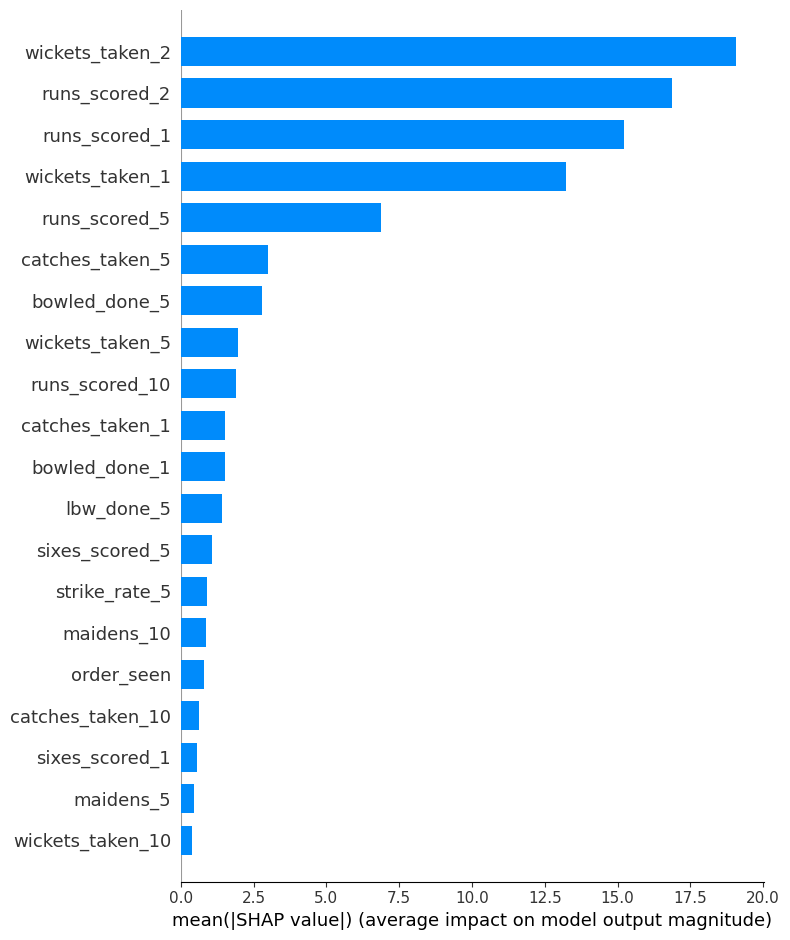

In [221]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

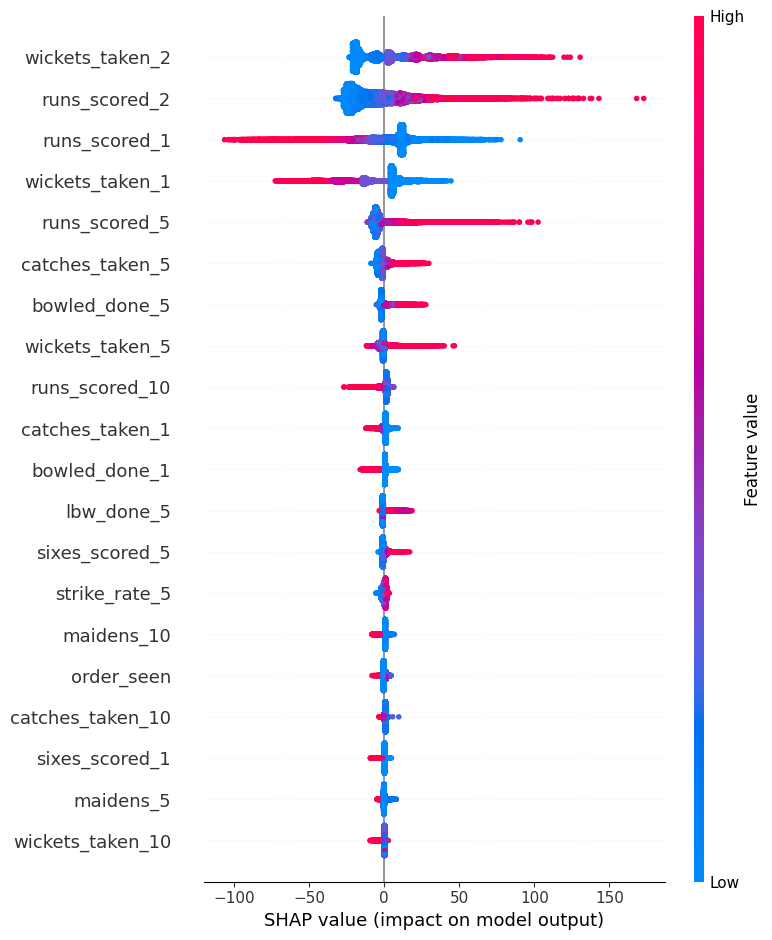

In [222]:
shap.summary_plot(shap_values, X_test)

In [223]:
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)
shap_df

,player_id,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test,runs_scored_1,runs_scored_2,runs_scored_5,runs_scored_10,...,maidens_1,maidens_5,maidens_10,strike_rate_1,strike_rate_5,strike_rate_10,economy_rate_1,economy_rate_5,economy_rate_10,order_seen
0,-0.000027,0.031687,-0.074855,0.158357,-0.130403,-0.109361,12.605395,-25.369181,-7.447656,0.671321,...,0.014916,-0.333169,0.622574,-0.210648,-0.200560,0.005061,0.014469,-0.212171,0.004338,-0.480869
1,-0.000518,0.031511,-0.028220,0.154204,-0.173424,-0.095253,21.941517,-4.552632,-6.524912,0.568552,...,0.013845,-0.192150,0.572909,0.712337,0.916575,0.004761,-0.019249,-0.179116,0.007158,-0.691721
2,-0.000308,0.021139,-0.021312,0.150469,-0.260758,-0.093340,-6.512459,16.181372,6.142238,1.548522,...,0.013733,-0.153920,0.656974,0.066113,1.263881,0.004716,-0.023596,-0.208783,0.006036,-0.960925
3,-0.000001,0.024945,-0.021364,0.154432,-0.296846,-0.137975,-21.830788,11.180097,-3.020821,1.283497,...,0.013318,-0.137559,0.719215,0.327366,2.090662,0.002917,-0.042261,-0.088902,0.006483,2.201392
4,-0.000282,0.052500,-0.035663,0.114327,-0.151267,-0.109377,5.942012,-19.409996,-5.024079,1.675701,...,0.015200,-0.340920,0.653765,-0.038396,-0.680434,0.004924,-0.190759,-0.277681,0.004473,-0.643439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43427,-0.004326,0.036173,-0.101899,-0.945831,0.019785,-0.049983,-34.177177,35.620823,14.040463,0.633327,...,-0.442184,0.827763,0.118504,-0.007023,1.335643,0.011405,-0.004783,0.052207,0.005309,1.413976
43428,-0.000631,0.033487,-0.116992,-1.469919,-0.116210,-0.048661,-11.693105,23.619965,10.338856,2.818312,...,0.041423,-0.360765,0.563963,-0.059386,1.452204,0.008505,0.006961,0.053904,0.006538,1.269178
43429,-0.000549,0.092612,-0.114867,-1.649389,0.038505,-0.041567,-24.563402,14.032845,-0.082091,1.487343,...,0.040989,-0.099691,0.583014,0.282448,1.482479,0.008475,0.005096,0.053379,0.006742,0.394608
43430,-0.000194,0.083175,-0.047362,0.126786,-0.100487,-0.034754,15.212108,-13.991372,-8.053960,-0.537305,...,0.014709,0.363897,0.989460,0.114869,1.361489,0.003533,0.009009,0.085469,0.004861,1.296574


In [224]:
test_df_features['predicted_fantasy_score_total'] = fantasy_score_total_predicted

/tmp/ipython-input-224-3441801569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_features['predicted_fantasy_score_total'] = fantasy_score_total_predicted


In [225]:
test_df_features

,player_id,start_date,name_x,fantasy_score_total,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test,match_id,...,maidens_5,maidens_10,strike_rate_1,strike_rate_5,strike_rate_10,economy_rate_1,economy_rate_5,economy_rate_10,order_seen,predicted_fantasy_score_total
373280,7637,2024-07-01,C Gomez,-2,0,0,0,1,0,1428459,...,0.000044,0.008856,40.000000,73.495796,78.486920,66.666667,146.251129,140.847857,0,5.841277
373281,394,2024-07-01,PHKD Mendis,37,0,0,0,1,0,1428459,...,0.000003,0.002174,135.000000,124.857347,108.140107,160.000000,146.575036,145.853933,0,44.434734
373282,6283,2024-07-01,AD Mathews,66,0,0,0,1,0,1428459,...,0.000004,0.002657,135.000000,124.857347,108.140107,133.333333,139.862553,142.710362,0,50.312454
373283,8563,2024-07-01,MNK Fernando,17,0,0,0,1,0,1428459,...,0.000006,0.003247,185.000000,119.786020,102.171242,176.666667,156.389642,147.360368,3,21.173668
373284,6103,2024-07-01,Mohammad Hasnain,27,0,0,0,1,0,1428459,...,0.000020,0.005928,46.153846,61.777818,71.580827,176.666667,156.389642,147.360368,0,28.786617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416707,1587,2025-05-20,E Corney,42,0,0,1,0,0,1462374,...,0.377848,0.260951,88.059701,109.071925,108.692056,91.666667,99.700640,105.694318,2,44.350193
416708,7111,2025-05-20,A Wellington,96,0,0,1,0,0,1462374,...,0.066773,0.096717,66.666667,119.578036,113.277023,91.935484,105.726120,109.504298,7,66.429016
416709,10032,2025-05-20,C Skelton,13,0,0,1,0,0,1462374,...,0.100159,0.118210,171.428571,146.033721,123.634881,91.935484,105.726120,109.504298,8,27.552618
416710,10220,2025-05-20,DP Conway,16,0,0,0,1,0,1473500,...,0.074637,0.116939,125.000000,131.117036,121.959953,89.285714,95.902567,102.279715,2,27.946220


## Evaluation

In [226]:
evaluation_df = (

    test_df_features.groupby('match_id').apply(

        lambda x: pd.Series({

            'actual_top_11_sum' : x['fantasy_score_total'].nlargest(10).sum(),
            'predicted_top_11_sum' : x['predicted_fantasy_score_total'].nlargest(10).sum()

        })

    ).reset_index()

)

/tmp/ipython-input-226-2611152996.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df_features.groupby('match_id').apply(


In [227]:
evaluation_df

,match_id,actual_top_11_sum,predicted_top_11_sum
0,1385691,1081.0,1107.634766
1,1385692,1722.0,1712.242432
2,1385693,1304.0,1383.005005
3,1385694,1497.0,1412.174438
4,1385695,1585.0,1470.991455
...,...,...,...
1960,1484052,725.0,693.035278
1961,1485778,629.0,585.831482
1962,1486225,799.0,709.955200
1963,1486227,671.0,596.094360


In [228]:
evaluation_df['absolute_percentage_error'] = (
    (evaluation_df['predicted_top_11_sum'] - evaluation_df['actual_top_11_sum']).abs() /
    evaluation_df['actual_top_11_sum']
) * 100


In [229]:
evaluation_df

,match_id,actual_top_11_sum,predicted_top_11_sum,absolute_percentage_error
0,1385691,1081.0,1107.634766,2.463901
1,1385692,1722.0,1712.242432,0.566642
2,1385693,1304.0,1383.005005,6.058666
3,1385694,1497.0,1412.174438,5.666370
4,1385695,1585.0,1470.991455,7.192968
...,...,...,...,...
1960,1484052,725.0,693.035278,4.408927
1961,1485778,629.0,585.831482,6.863039
1962,1486225,799.0,709.955200,11.144531
1963,1486227,671.0,596.094360,11.163285


In [230]:
mean_absolute_percentage_error = evaluation_df['absolute_percentage_error'].mean()

In [231]:
print(f"Mean absolute percentage error across all matches : {mean_absolute_percentage_error}" )

Mean absolute percentage error across all matches : 8.250770718735893


In [232]:
evaluation_df['percentage_error'] = (
        (evaluation_df['predicted_top_11_sum'] - evaluation_df['actual_top_11_sum']) /
    evaluation_df['actual_top_11_sum']
) * 100


In [233]:
evaluation_df = evaluation_df[evaluation_df['actual_top_11_sum'] != 0]

In [234]:
mean_percentage_error = evaluation_df['percentage_error'].mean()

In [235]:
zero_count = (evaluation_df['actual_top_11_sum'] == 0).sum()
print(f"Number of zeros in actual_top_11_sum: {zero_count}")

Number of zeros in actual_top_11_sum: 0


In [236]:
print(f"Mean percentage error across all matches : {mean_percentage_error}" )

Mean percentage error across all matches : -5.090900176344548


In [237]:
evaluation_df

,match_id,actual_top_11_sum,predicted_top_11_sum,absolute_percentage_error,percentage_error
0,1385691,1081.0,1107.634766,2.463901,2.463901
1,1385692,1722.0,1712.242432,0.566642,-0.566642
2,1385693,1304.0,1383.005005,6.058666,6.058666
3,1385694,1497.0,1412.174438,5.666370,-5.666370
4,1385695,1585.0,1470.991455,7.192968,-7.192968
...,...,...,...,...,...
1960,1484052,725.0,693.035278,4.408927,-4.408927
1961,1485778,629.0,585.831482,6.863039,-6.863039
1962,1486225,799.0,709.955200,11.144531,-11.144531
1963,1486227,671.0,596.094360,11.163285,-11.163285


## Plotting actual_top_11_sum vs predicted_top_11_sum

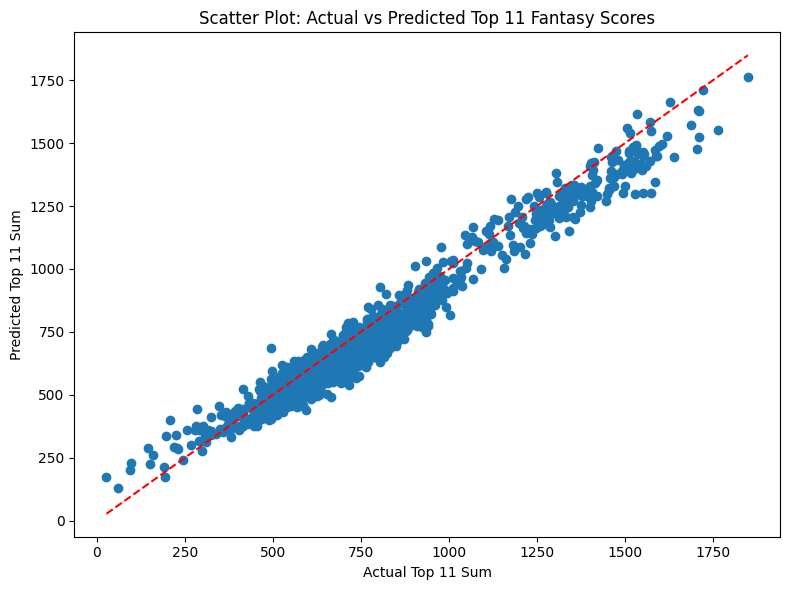

In [238]:
plt.figure(figsize=(8, 6))
plt.scatter(
    evaluation_df['actual_top_11_sum'],
    evaluation_df['predicted_top_11_sum'],
)
plt.plot([evaluation_df['actual_top_11_sum'].min(), evaluation_df['actual_top_11_sum'].max()],
         [evaluation_df['actual_top_11_sum'].min(), evaluation_df['actual_top_11_sum'].max()],
         color='red', linestyle='--')

plt.xlabel('Actual Top 11 Sum')
plt.ylabel('Predicted Top 11 Sum')
plt.title('Scatter Plot: Actual vs Predicted Top 11 Fantasy Scores')

plt.tight_layout()
plt.show()


In [239]:
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Applying RFECV:

In [165]:
model2 = XGBRegressor(n_estimators=100, random_state=42)

In [ ]:
rfecv = RFECV(estimator=model2, step = 1, cv=5, scoring = 'neg_mean_squared_error', n_jobs = -1)
rfecv.fit(X_train_scaled, y_train)

In [ ]:

print(f"Number of optimal features: {rfecv.n_features_}")
print("Selected features:", X_train.columns[rfecv.support_].tolist())

In [ ]:
X_train_selected = rfecv.transform(X_train_scaled)
X_test_selected = rfecv.transform(X_test_scaled)

In [ ]:
model3.fit(X_train_selected, y_train)
fantasy_score_total_predicted3 = model3.predict(X_test_selected)

In [ ]:
print("RMSE:", mean_squared_error(y_test, fantasy_score_total_predicted3))
print("R² Score:", r2_score(y_test, fantasy_score_total_predicted3))

In [ ]:
explainer = shap.TreeExplainer(model3)
shap_values = explainer.shap_values(X_test_selected)
shap.summary_plot(shap_values, X_test_selected, plot_type="bar")

In [ ]:
test_df_features['predicted_fantasy_score_total_exp3'] = fantasy_score_total_predicted3

In [ ]:
evaluation_df = (

    test_df_features.groupby('match_id').apply(

        lambda x: pd.Series({

            'actual_top_11_sum' : x['fantasy_score_total'].nlargest(10).sum(),
            'predicted_top_11_sum_exp1' : x['predicted_fantasy_score_total'].nlargest(10).sum(),
            'predicted_top_11_sum_exp2' : x['predicted_fantasy_score_total_exp2'].nlargest(10).sum()


        })

    ).reset_index()

)

In [ ]:
evaluation_df['absolute_percentage_error_exp2'] = (
    (evaluation_df['predicted_top_11_sum_exp2'] - evaluation_df['actual_top_11_sum']).abs() /
    evaluation_df['actual_top_11_sum']
) * 100

In [ ]:
evaluation_df['percentage_error_exp2'] = (
        (evaluation_df['predicted_top_11_sum_exp2'] - evaluation_df['actual_top_11_sum']) /
    evaluation_df['actual_top_11_sum']
)*100

In [ ]:
evaluation_df = evaluation_df[evaluation_df['actual_top_11_sum'] != 0]

In [ ]:
mean_absolute_percentage_error = evaluation_df['absolute_percentage_error_exp2'].mean()

In [ ]:
mean_percentage_error = evaluation_df['percentage_error_exp2'].mean()

In [ ]:
print(f"Mean absolute percentage error across all matches : {mean_absolute_percentage_error}%" )

In [ ]:
print(f"percentage error across all matches : {mean_percentage_error}%" )

In [ ]:

plt.scatter(
    evaluation_df['actual_top_11_sum'],
    evaluation_df['predicted_top_11_sum_exp2'],
)
plt.plot([evaluation_df['actual_top_11_sum'].min(), evaluation_df['actual_top_11_sum'].max()],
         [evaluation_df['actual_top_11_sum'].min(), evaluation_df['actual_top_11_sum'].max()],
         color='red', linestyle='--')

plt.xlabel('Actual Top 11 Sum')
plt.ylabel('Predicted Top 11 Sum')
plt.title('Actual vs Predicted Top 11 Fantasy Scores')

plt.tight_layout()
plt.show()

# TEST

In [240]:
df_features

,player_id,start_date,name_x,fantasy_score_total,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test,match_id,...,maidens_1,maidens_5,maidens_10,strike_rate_1,strike_rate_5,strike_rate_10,economy_rate_1,economy_rate_5,economy_rate_10,order_seen
0,11182,2001-12-19,C White,49,0,0,0,0,1,63963,...,0.0,0.000000,0.000000,66.666667,66.666667,66.666667,0.000000,0.000000,0.000000,7
1,1878,2001-12-19,SS Das,44,0,0,0,0,1,63963,...,18.0,7.263168,4.666414,35.000000,31.255504,33.429867,38.235294,39.408064,44.769324,0
2,10153,2001-12-19,A Flintoff,84,0,0,0,0,1,63963,...,0.0,1.894752,1.703394,26.666667,29.383256,33.080949,31.176471,40.287642,46.543999,6
3,11344,2001-12-19,N Hussain,62,0,0,0,0,1,63963,...,8.0,2.842127,2.081926,0.000000,30.741551,34.506345,31.176471,40.287642,46.543999,3
4,10707,2001-12-19,ME Trescothick,38,0,0,0,0,1,63963,...,0.0,0.263191,0.766799,67.187500,46.112327,42.174421,16.666667,55.662744,52.779079,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416707,1587,2025-05-20,E Corney,42,0,0,1,0,0,1462374,...,1.0,0.377848,0.260951,88.059701,109.071925,108.692056,91.666667,99.700640,105.694318,2
416708,7111,2025-05-20,A Wellington,96,0,0,1,0,0,1462374,...,0.0,0.066773,0.096717,66.666667,119.578036,113.277023,91.935484,105.726120,109.504298,7
416709,10032,2025-05-20,C Skelton,13,0,0,1,0,0,1462374,...,0.0,0.100159,0.118210,171.428571,146.033721,123.634881,91.935484,105.726120,109.504298,8
416710,10220,2025-05-20,DP Conway,16,0,0,0,1,0,1473500,...,0.0,0.074637,0.116939,125.000000,131.117036,121.959953,89.285714,95.902567,102.279715,2


In [184]:
# import pandas as pd
# import numpy as np
# from typing import List
# from datetime import datetime

# def get_top_11_players(
#     player_ids: List[int],
#     match_date: str,
#     model,  # Your trained model
#     df_features: pd.DataFrame  # Your engineered DataFrame
# ) -> pd.DataFrame:
#     """
#     Get top 11 players based on predicted fantasy scores
#     """

#     # Convert date string to datetime
#     match_date = pd.to_datetime(match_date)

#     # Get latest features for each player before the match date
#     player_features = []

#     for player_id in player_ids:
#         # Get player's historical data up to the match date
#         player_data = df_features[
#             (df_features['player_id'] == player_id) &
#             (df_features['start_date'] <= match_date)
#         ].sort_values('start_date')

#         if len(player_data) > 0:
#             # Get the most recent features for this player
#             latest_features = player_data.iloc[-1].copy()
#             player_features.append(latest_features)
#         else:
#             print(f"Warning: No historical data found for player {player_id}")

#     if len(player_features) == 0:
#         print("Error: No valid player data found")
#         return pd.DataFrame()

#     # Convert to DataFrame
#     features_df = pd.DataFrame(player_features)

#     # FIXED: Use exact features that model was trained on (exclude player_id, match_id, start_date, fantasy_score_total)
#     model_features = [
#         'player_id',
#         'match_type_MDM', 'match_type_ODI', 'match_type_ODM', 'match_type_T20', 'match_type_Test',
#         'runs_scored_1', 'runs_scored_2', 'runs_scored_5', 'runs_scored_10',
#         'fours_scored_1', 'fours_scored_5', 'fours_scored_10',
#         'sixes_scored_1', 'sixes_scored_5', 'sixes_scored_10',
#         'catches_taken_1', 'catches_taken_5', 'catches_taken_10',
#         'run_out_direct_5', 'run_out_direct_10',
#         'run_out_throw_1', 'run_out_throw_5', 'run_out_throw_10',
#         'stumpings_done_5', 'stumpings_done_10',
#         'wickets_taken_1', 'wickets_taken_2', 'wickets_taken_5', 'wickets_taken_10',
#         'bowled_done_1', 'bowled_done_5', 'bowled_done_10',
#         'lbw_done_5', 'lbw_done_10',
#         'maidens_1', 'maidens_5', 'maidens_10',
#         'strike_rate_1', 'strike_rate_5', 'strike_rate_10',
#         'economy_rate_1', 'economy_rate_5', 'economy_rate_10',
#         'order_seen'
#     ]

#     # Check if all required features are present
#     missing_features = [f for f in model_features if f not in features_df.columns]
#     if missing_features:
#         print(f"Warning: Missing features: {missing_features}")
#         return pd.DataFrame()

#     # Prepare features for prediction (exact same order as training)
#     X_pred = features_df[model_features]

#     # Make predictions
#     predicted_scores = model.predict(X_pred)

#     # Create results DataFrame
#     results_df = pd.DataFrame({
#         'player_id': features_df['player_id'],
#         'player_name': features_df.get('player_name', [f"Player_{pid}" for pid in features_df['player_id']]),
#         'predicted_score': predicted_scores,
#         'latest_actual_score': features_df['fantasy_score_total'],
#         'last_match_date': features_df['start_date']
#     })

#     # Sort by predicted score and get top 11
#     top_11 = results_df.sort_values('predicted_score', ascending=False).head(11).reset_index(drop=True)

#     # Add rank
#     top_11['rank'] = range(1, 12)

#     return top_11[['rank', 'player_id', 'player_name', 'predicted_score', 'latest_actual_score', 'last_match_date']]

In [272]:
import pandas as pd
import numpy as np
from typing import List
from datetime import datetime

def get_top_11_players(
    player_ids: List[int],
    match_date: str,
    model,
    df_features: pd.DataFrame
) -> pd.DataFrame:
    """
    Get top 11 players based on predicted fantasy scores with player names

    Parameters:
    -----------
    player_ids : List[int]
        List of 22 player IDs
    match_date : str
        Date in format 'YYYY-MM-DD'
    model : trained model
        Your trained ML model for prediction
    df_features : pd.DataFrame
        Your feature-engineered DataFrame with player names

    Returns:
    --------
    pd.DataFrame
        Top 11 players with predicted scores, actual scores, and names
    """

    # Convert date string to datetime
    match_date = pd.to_datetime(match_date)

    # Get latest features for each player before the match date
    player_features = []

    for player_id in player_ids:
        # Get player's historical data up to the match date
        player_data = df_features[
            (df_features['player_id'] == player_id) &
            (df_features['start_date'] <= match_date)
        ].sort_values('start_date')

        if len(player_data) > 0:
            # Get the most recent features for this player
            latest_features = player_data.iloc[-1].copy()
            player_features.append(latest_features)
        else:
            print(f"Warning: No historical data found for player {player_id}")

    if len(player_features) == 0:
        print("Error: No valid player data found")
        return pd.DataFrame()

    # Convert to DataFrame
    features_df = pd.DataFrame(player_features)

    # Model features (exclude non-feature columns)
    model_features = [
        'player_id',
        'match_type_MDM', 'match_type_ODI', 'match_type_ODM', 'match_type_T20', 'match_type_Test',
        'runs_scored_1', 'runs_scored_2', 'runs_scored_5', 'runs_scored_10',
        'fours_scored_1', 'fours_scored_5', 'fours_scored_10',
        'sixes_scored_1', 'sixes_scored_5', 'sixes_scored_10',
        'catches_taken_1', 'catches_taken_5', 'catches_taken_10',
        'run_out_direct_5', 'run_out_direct_10',
        'run_out_throw_1', 'run_out_throw_5', 'run_out_throw_10',
        'stumpings_done_5', 'stumpings_done_10',
        'wickets_taken_1', 'wickets_taken_2', 'wickets_taken_5', 'wickets_taken_10',
        'bowled_done_1', 'bowled_done_5', 'bowled_done_10',
        'lbw_done_5', 'lbw_done_10',
        'maidens_1', 'maidens_5', 'maidens_10',
        'strike_rate_1', 'strike_rate_5', 'strike_rate_10',
        'economy_rate_1', 'economy_rate_5', 'economy_rate_10',
        'order_seen'
    ]

    # Check if all required features are present
    missing_features = [f for f in model_features if f not in features_df.columns]
    if missing_features:
        print(f"Warning: Missing features: {missing_features}")
        return pd.DataFrame()

    # Prepare features for prediction
    X_pred = features_df[model_features]

    # Make predictions
    predicted_scores = model.predict(X_pred)

    # Create results DataFrame with player names (CHANGED: using 'name_x' column)
    results_df = pd.DataFrame({
        'player_id': features_df['player_id'],
        'player_name': features_df['name_x'],  # CHANGED: Now using 'name_x' column
        'predicted_score': predicted_scores,
        'latest_actual_score': features_df['fantasy_score_total'],
        'last_match_date': features_df['start_date']
    })

    # Sort by predicted score and get top 11
    top_11 = results_df.sort_values('predicted_score', ascending=False).head(11).reset_index(drop=True)

    # Add rank
    top_11['rank'] = range(1, 12)

    return top_11[['rank', 'player_id', 'player_name', 'predicted_score', 'latest_actual_score', 'last_match_date']]


# Helper function to get 22 players from a match
def get_players_from_match(match_id: int, df_features: pd.DataFrame) -> List[int]:
    """Get list of player IDs from a specific match"""
    match_players = df_features[df_features['match_id'] == match_id]['player_id'].unique().tolist()
    return match_players


def display_dream_team(top_11_df: pd.DataFrame):
    """Display the dream team in a beautiful format"""

    print("\n" + "="*80)
    print("🏏 DREAM TEAM - TOP 11 PLAYERS 🏏")

    for _, row in top_11_df.iterrows():
        print(f"{row['rank']:2d}. {row['player_name']:<25} | "
              f"ID: {row['player_id']:<8} | "
              f"Predicted: {row['predicted_score']:6.1f} | "
              f"Last Score: {row['latest_actual_score']:6.1f}")

    print("="*80)
    print(f"💯 Total Predicted Score: {top_11_df['predicted_score'].sum():.1f}")
    print(f"💯 Total Last Actual Score: {top_11_df['latest_actual_score'].sum():.1f}")
    print(f"📊 Average Predicted Score: {top_11_df['predicted_score'].mean():.1f}")
    print(f"🎯 Best Player: {top_11_df.iloc[0]['player_name']} ({top_11_df.iloc[0]['predicted_score']:.1f})")
    print("="*80)

In [273]:
# Check what match IDs actually exist in your dataset
print("Available match IDs in your dataset:")
available_matches = df_features['match_id'].unique()
print(f"Total matches: {len(available_matches)}")
print(f"Sample match IDs: {available_matches}")  # Show first 10

# Check the specific match ID you tried
print(f"\n{'63963' in available_matches}")

Available match IDs in your dataset:
Total matches: 18896
Sample match IDs: ['63963' '64012' '64022' ... '1462374' '1473500' '1485778']

True


In [276]:
# Use an actual match ID from your dataset
actual_match_id = '1473461'  # or pick any from the list above

player_ids = get_players_from_match(actual_match_id, df_features)
print(f"Found {len(player_ids)} players in match {actual_match_id}")
print(f"Player IDs: {player_ids}")

# Get top 11 predictions
match_date = "2024-05-15"  # Use a date that makes sense for your data

top_11_dream_team = get_top_11_players(
    player_ids=player_ids,
    match_date=match_date,
    model=model,
    df_features=df_features
)

print("\n🏏 Dream Team - Top 11 Players:")
print(top_11_dream_team)

display_dream_team(top_11_dream_team)

Found 24 players in match 1473461
Player IDs: [179, 8152, 11065, 1989, 2801, 2030, 6072, 4388, 8564, 7946, 5400, 7121, 3677, 2347, 6109, 5888, 2078, 2906, 2097, 4176, 6445, 5232, 9164, 6786]

🏏 Dream Team - Top 11 Players:
    rank  player_id    player_name  predicted_score  latest_actual_score  \
0      1       6109       T Stubbs       108.047241                  111   
1      2       5232     Yash Dayal       105.227036                  117   
2      3        179   JR Hazlewood        95.645485                  133   
3      4       9164     RM Patidar        77.102676                   77   
4      5       5400      MM Sharma        73.131950                   83   
5      6       7946  Abishek Porel        66.510277                   87   
6      7       5888      JM Sharma        59.794235                   44   
7      8       2097        B Kumar        49.304966                   60   
8      9       8564        V Kohli        41.260059                   44   
9     10       20